# High Mountain Asia UCLA Daily Snow Reanalysis, Version 1
Snowpack plays a significant role in the hydrologic cycle over High Mountain Asia (HMA). As a vital water resource, the distribution of snowpack volume also impacts the water availability for downstream populations. To assess the regional water balance, it is important to characterize the spatio-temporal distribution of water storage in the HMA snowpack.
This HMA snow reanalysis data set contains daily estimates of posterior snow water equivalent (SWE), fractional snow covered area (fSCA), snow depth (SD), etc.

https://nsidc.org/data/HMA_SR_D/versions/1

/!\ non seasonal snow may be not reliable because of snow scheme /!\

Stats:  ensemble mean, ensemble standard deviation, ensemble median, 25th percentile, and 75th percentile

Download 24/06/2021

In [51]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Try with one tile (1°x1°)

In [2]:
path = '/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/'

### Load sd, swe and sca

In [78]:
ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SD_POST.nc')
# ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_SD_POST.nc')
sd = ds.SD_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat'}).transpose("Day", "lat", "lon")

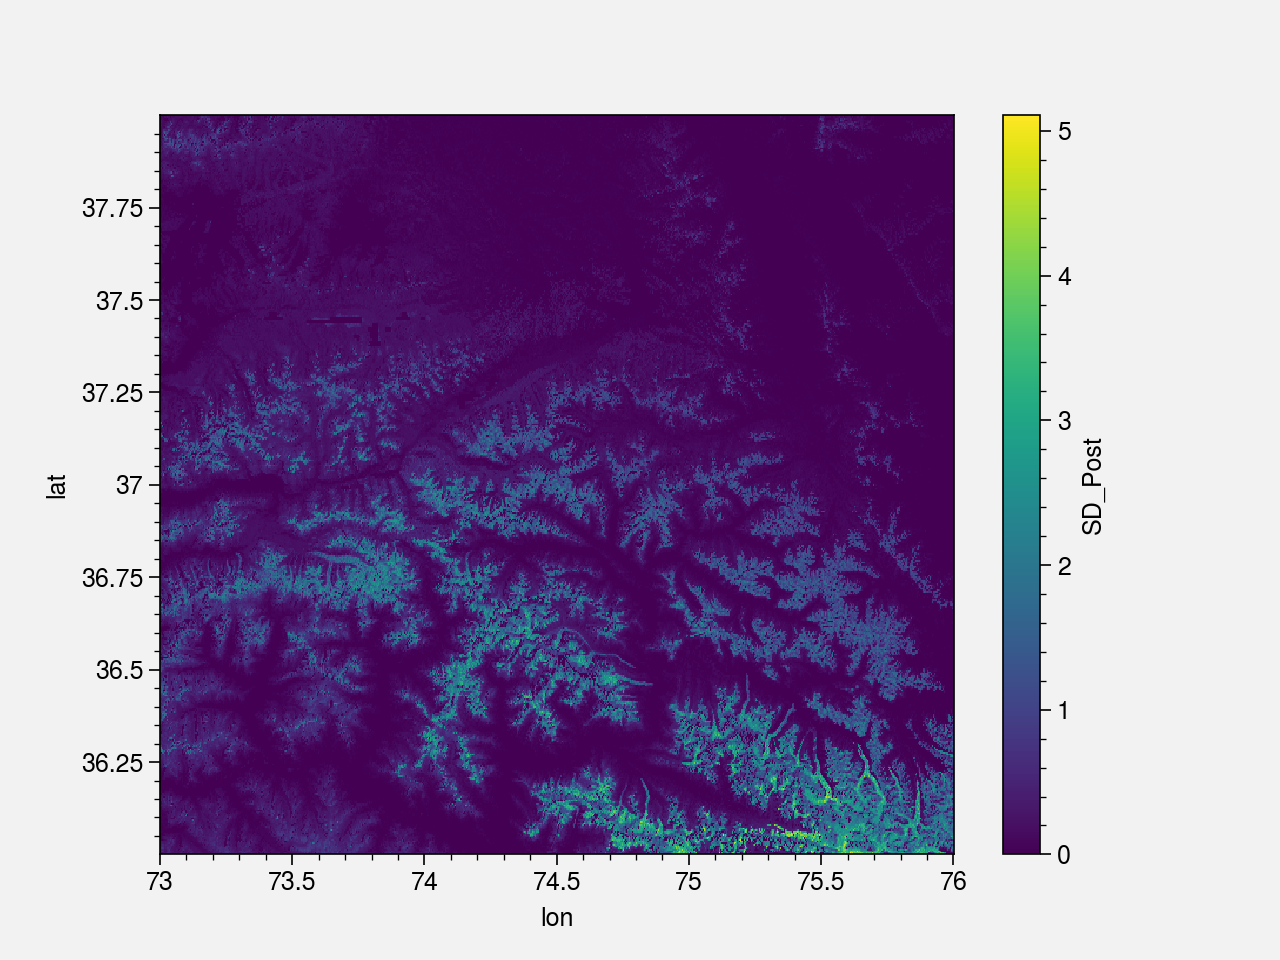

In [79]:
sd.mean('Day').plot()

In [80]:
ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SWE_SCA_POST.nc')
# ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_SWE_SCA_POST.nc')
swe = ds.SWE_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat'}).transpose("Day", "lat", "lon")
sca = ds.SCA_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat'}).transpose("Day", "lat", "lon")

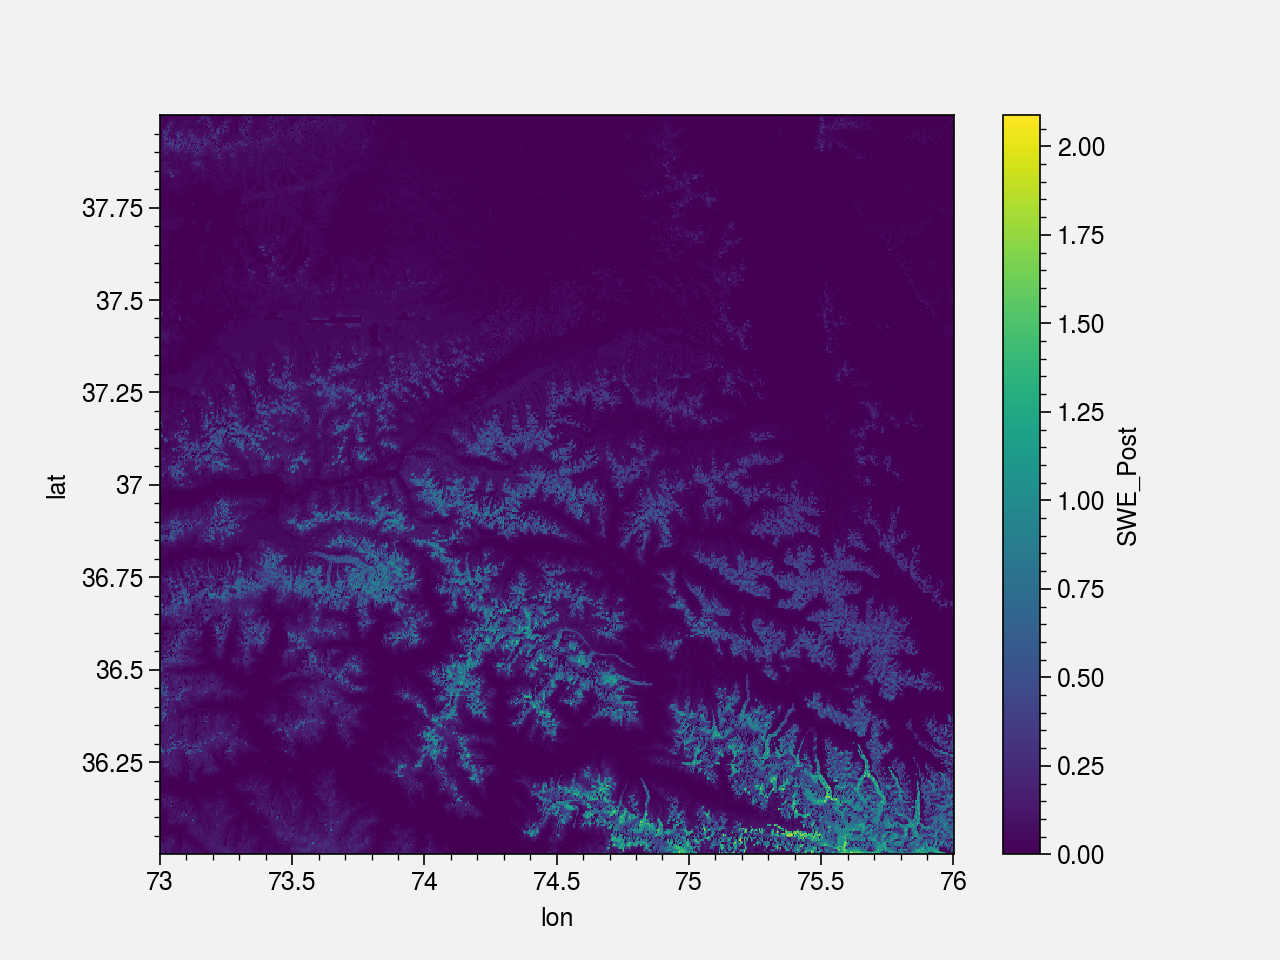

In [81]:
swe.mean('Day').plot()

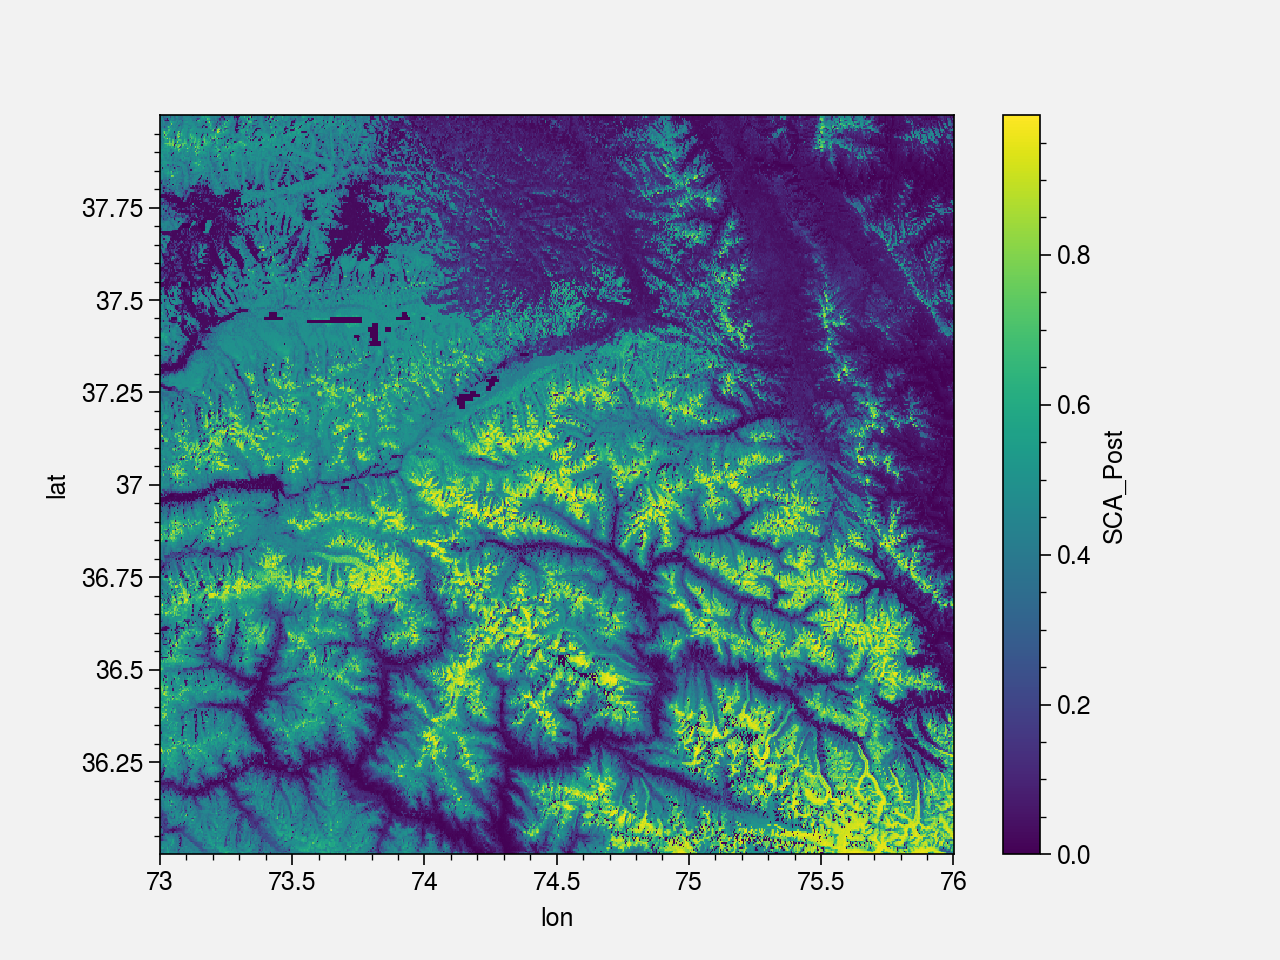

In [82]:
# Des valeurs bizarres à 0... probablement du à la classification 1 et/ou endroits de non seasonal snow
# Je vais tout garder mais à garder en tête que c'est pas parfait et qu'il y a des artefacts !
sca.mean('Day').plot()

### Coarsen values to 0.2° (~20km)

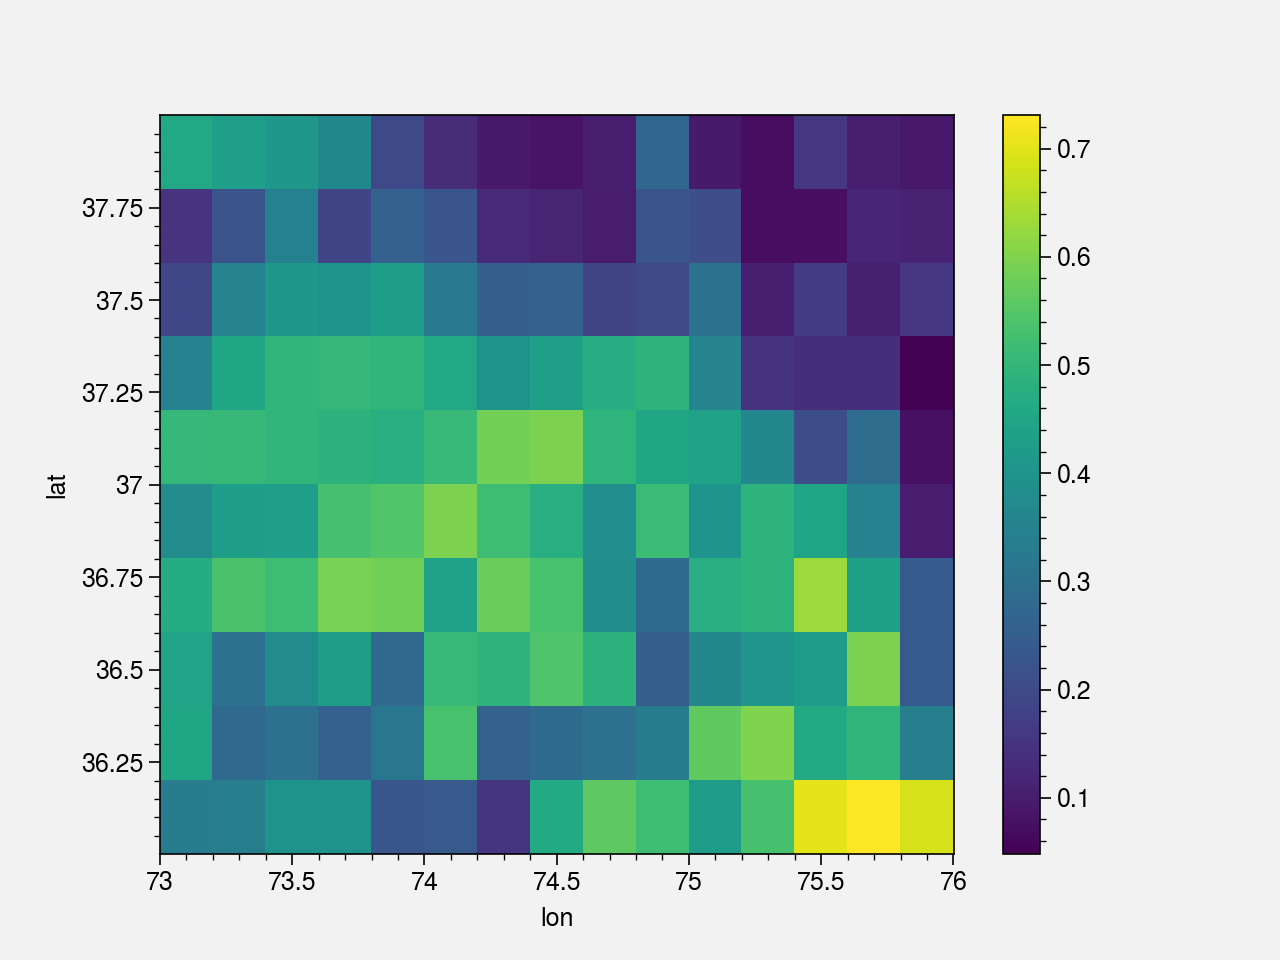

In [83]:
sca.coarsen(lat=45, lon=45).mean().mean('Day').plot()

In [84]:
sd_20km = sd.coarsen(lat=45, lon=45).mean().load()
swe_20km = swe.coarsen(lat=45, lon=45).mean().load()
sca_20km = sca.coarsen(lat=45, lon=45).mean().load()

## Load topo 
Attention les lat/lon sont inversées dans la réanalyse

In [59]:
latlim, lonlim = u.get_domain_HMA()
root_data_path = '/home/lalandmi/Dropbox/data/' # local
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

ds = xr.open_dataset(root_data_path+'GMTED2010/GMTED2010_15n060_0250deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

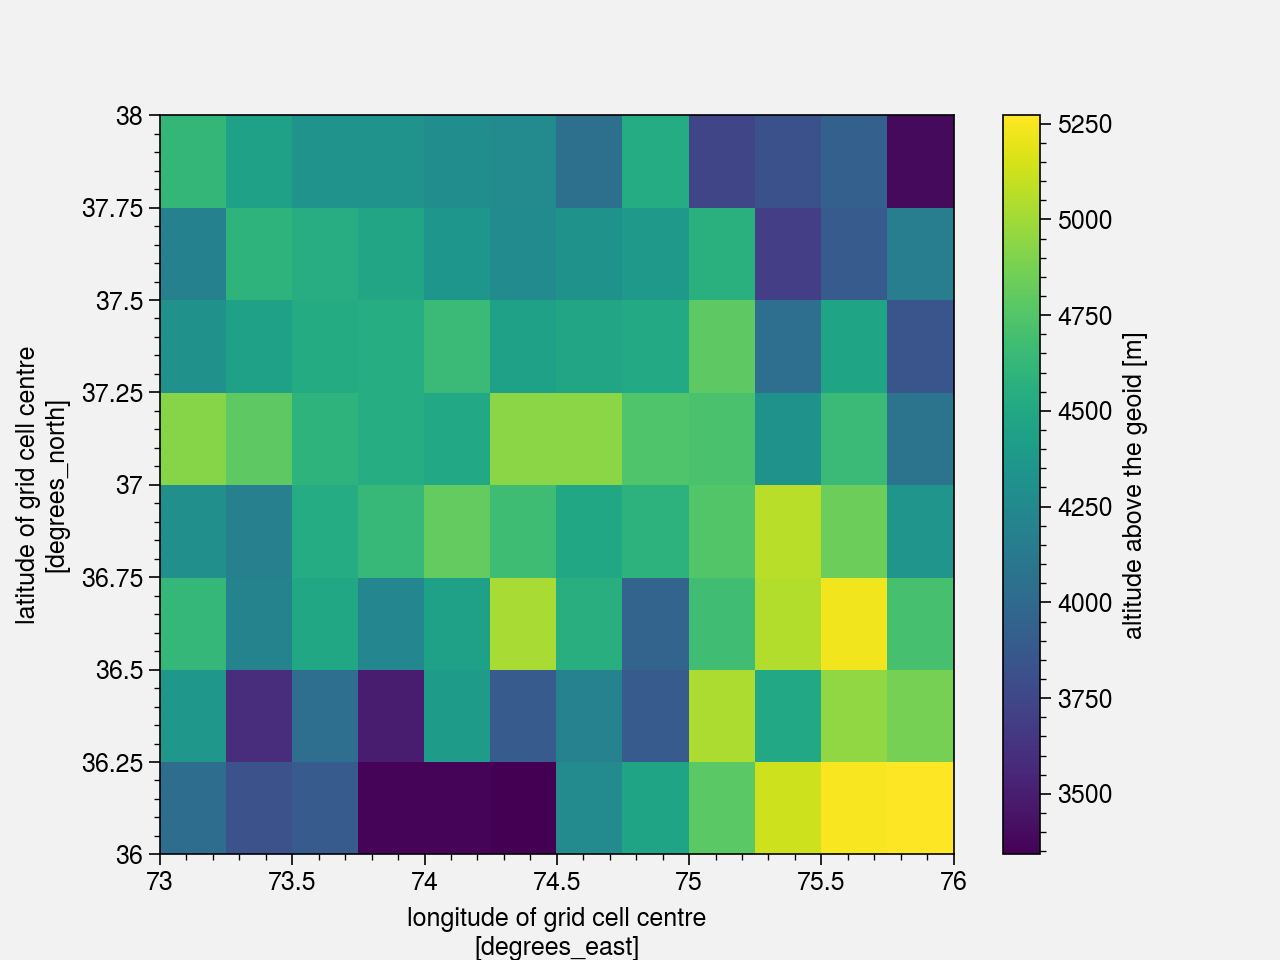

In [60]:
elevation.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max())).plot()

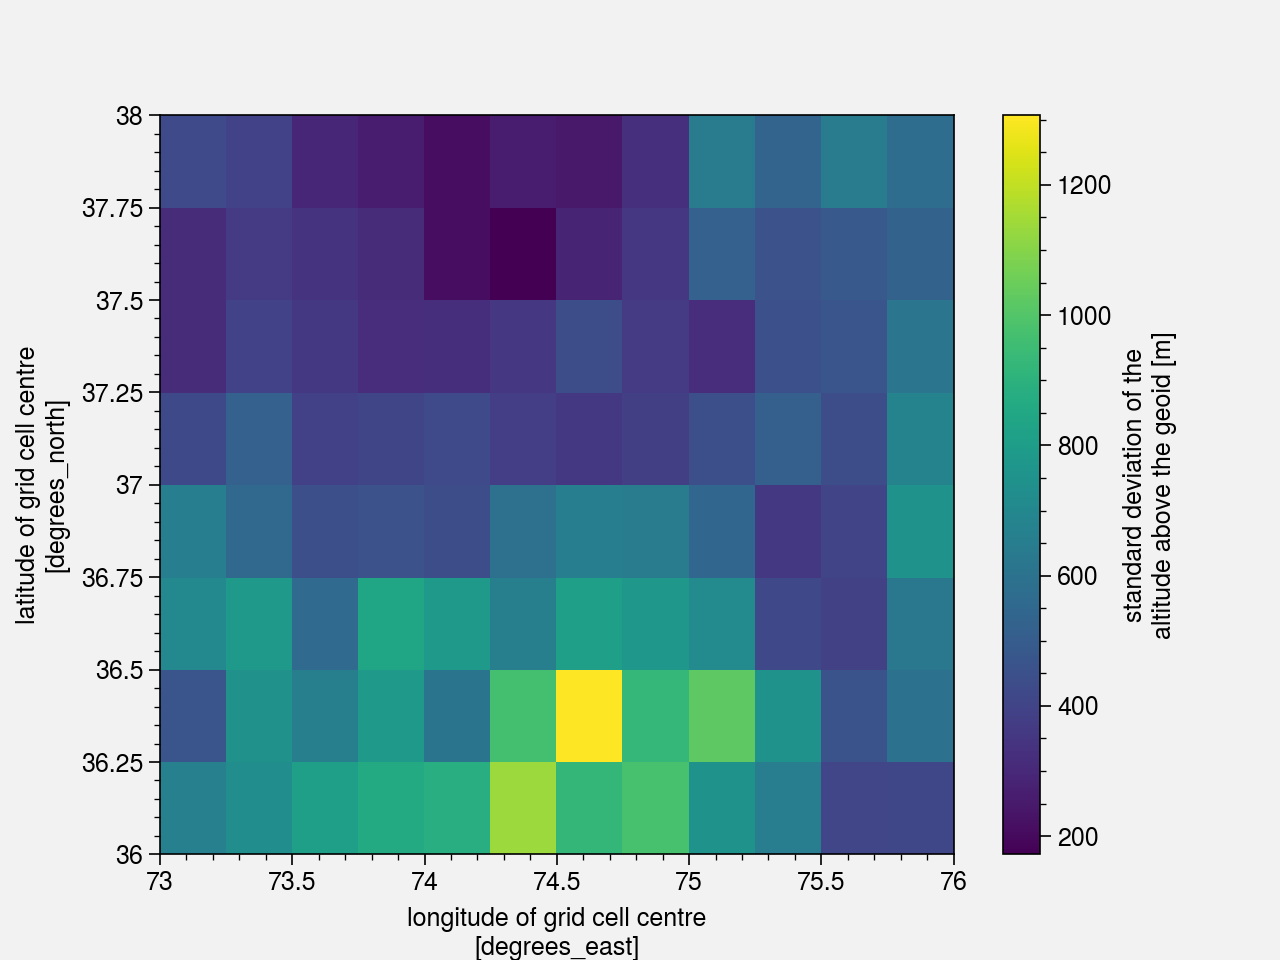

In [61]:
elevation_std.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max())).plot()

In [62]:
elevation_subset = elevation.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max()))

## Regrid

In [85]:
regridder = xe.Regridder(sd_20km, elevation_subset, 'bilinear', periodic=False, reuse_weights=True)
sd_regrid = regridder(sd_20km)
swe_regrid = regridder(swe_20km)
sca_regrid = regridder(sca_20km)

Create weight file: bilinear_10x15_8x12.nc


## Check SCA/SWE relationship

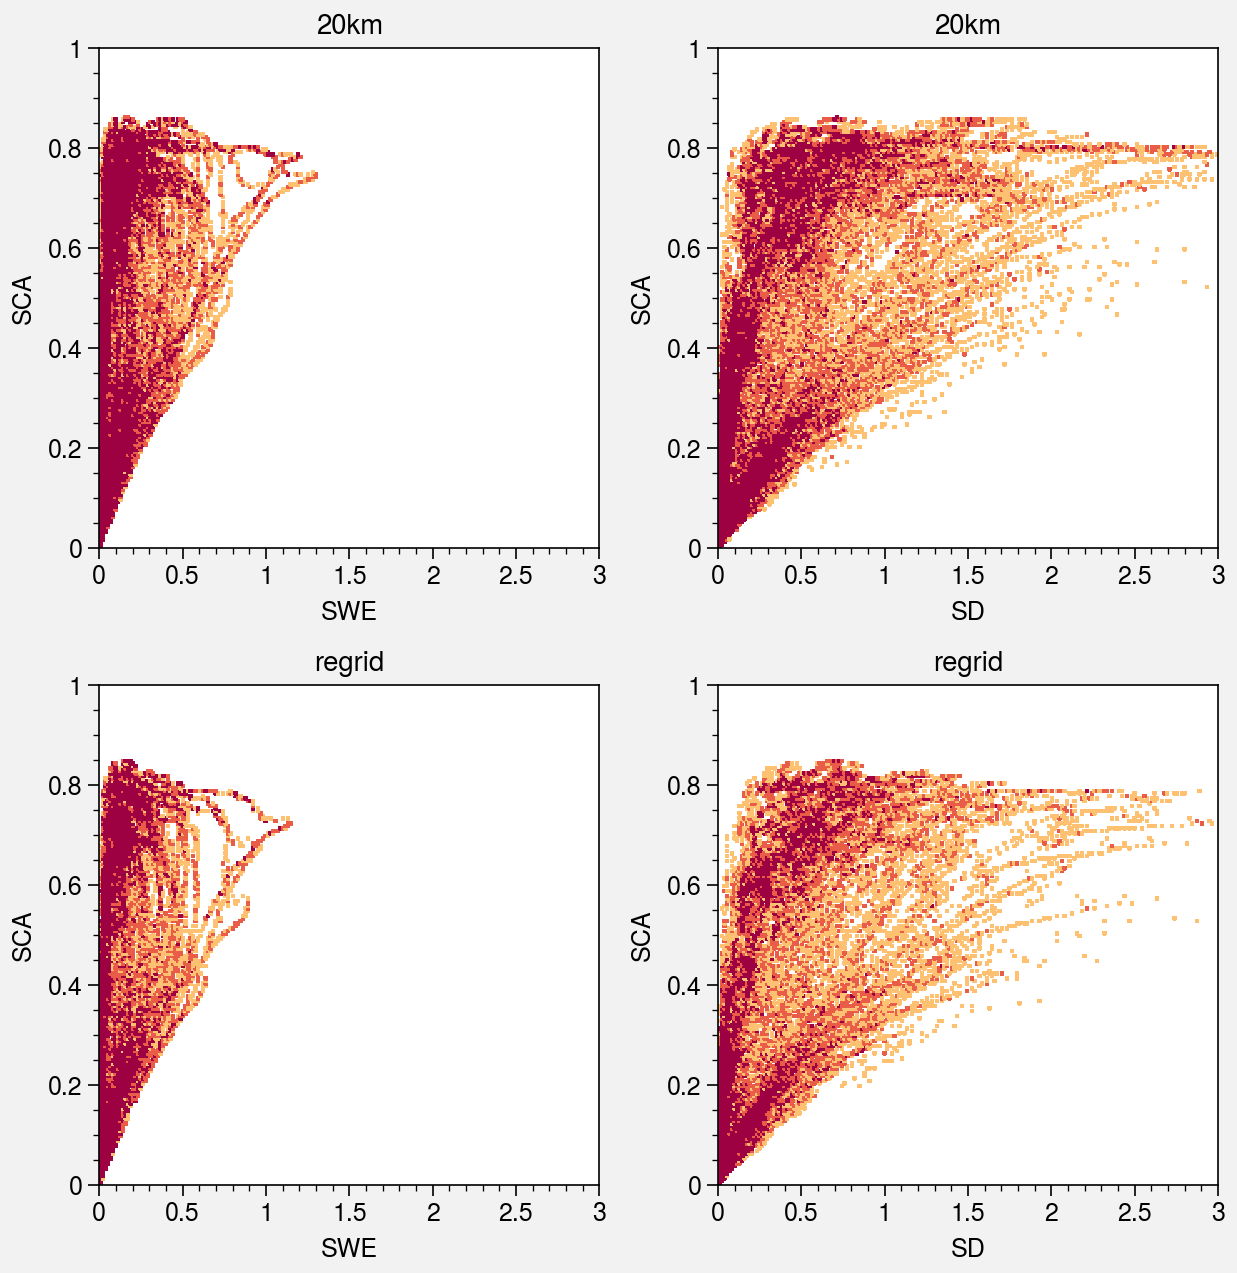

In [155]:
bins = 200
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1
xylim = [[0, 3], [0, 1]]

fig, axs = plot.subplots(ncols=2, nrows=2, share=0)

axs[0].hist2d(swe_20km.values.flatten(), sca_20km.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[0].format(xlabel='SWE', ylabel='SCA', title='20km')

axs[1].hist2d(sd_20km.values.flatten(), sca_20km.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[1].format(xlabel='SD', ylabel='SCA', title='20km')

axs[2].hist2d(swe_regrid.values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[2].format(xlabel='SWE', ylabel='SCA', title='regrid')

axs[3].hist2d(sd_regrid.values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[3].format(xlabel='SD', ylabel='SCA', title='regrid')

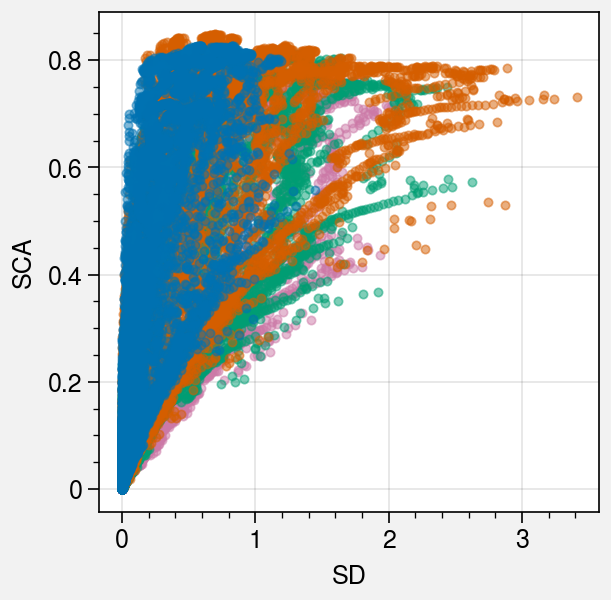

In [200]:
fig, axs = plot.subplots()

axs[0].scatter((sd_regrid.where(elevation_std < 400)).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[0].scatter((sd_regrid.where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[0].scatter((sd_regrid.where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[0].scatter((sd_regrid.where((elevation_std > 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=7)



axs.format(xlabel='SD', ylabel='SCA')



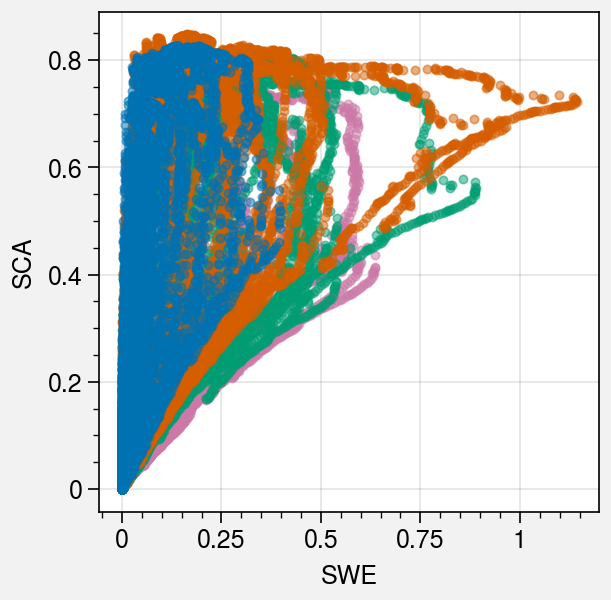

In [201]:
fig, axs = plot.subplots()

axs[0].scatter((swe_regrid.where(elevation_std < 400)).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[0].scatter((swe_regrid.where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[0].scatter((swe_regrid.where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[0].scatter((swe_regrid.where((elevation_std > 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=7)



axs.format(xlabel='SWE', ylabel='SCA')



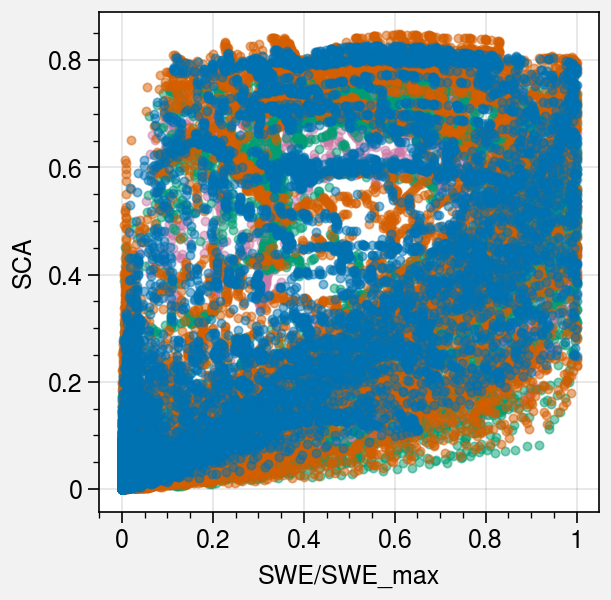

In [203]:
fig, axs = plot.subplots()

axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where(elevation_std < 400)).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=7)

axs.format(xlabel='SWE/SWE_max', ylabel='SCA')

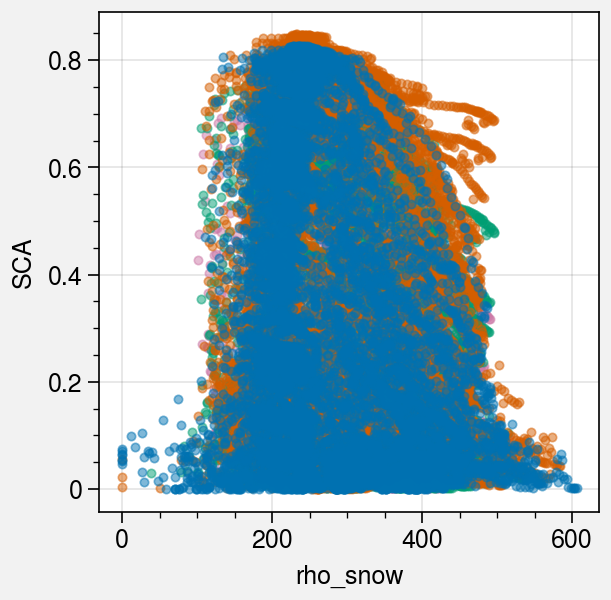

In [207]:
fig, axs = plot.subplots()

axs[0].scatter(((swe_regrid/sd_regrid*1000).where(elevation_std < 400)).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[0].scatter(((swe_regrid/sd_regrid*1000).where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[0].scatter(((swe_regrid/sd_regrid*1000).where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[0].scatter(((swe_regrid/sd_regrid*1000).where((elevation_std > 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=7)

axs.format(xlabel='rho_snow', ylabel='SCA')

## Check Niu and Yan 2007

In [237]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

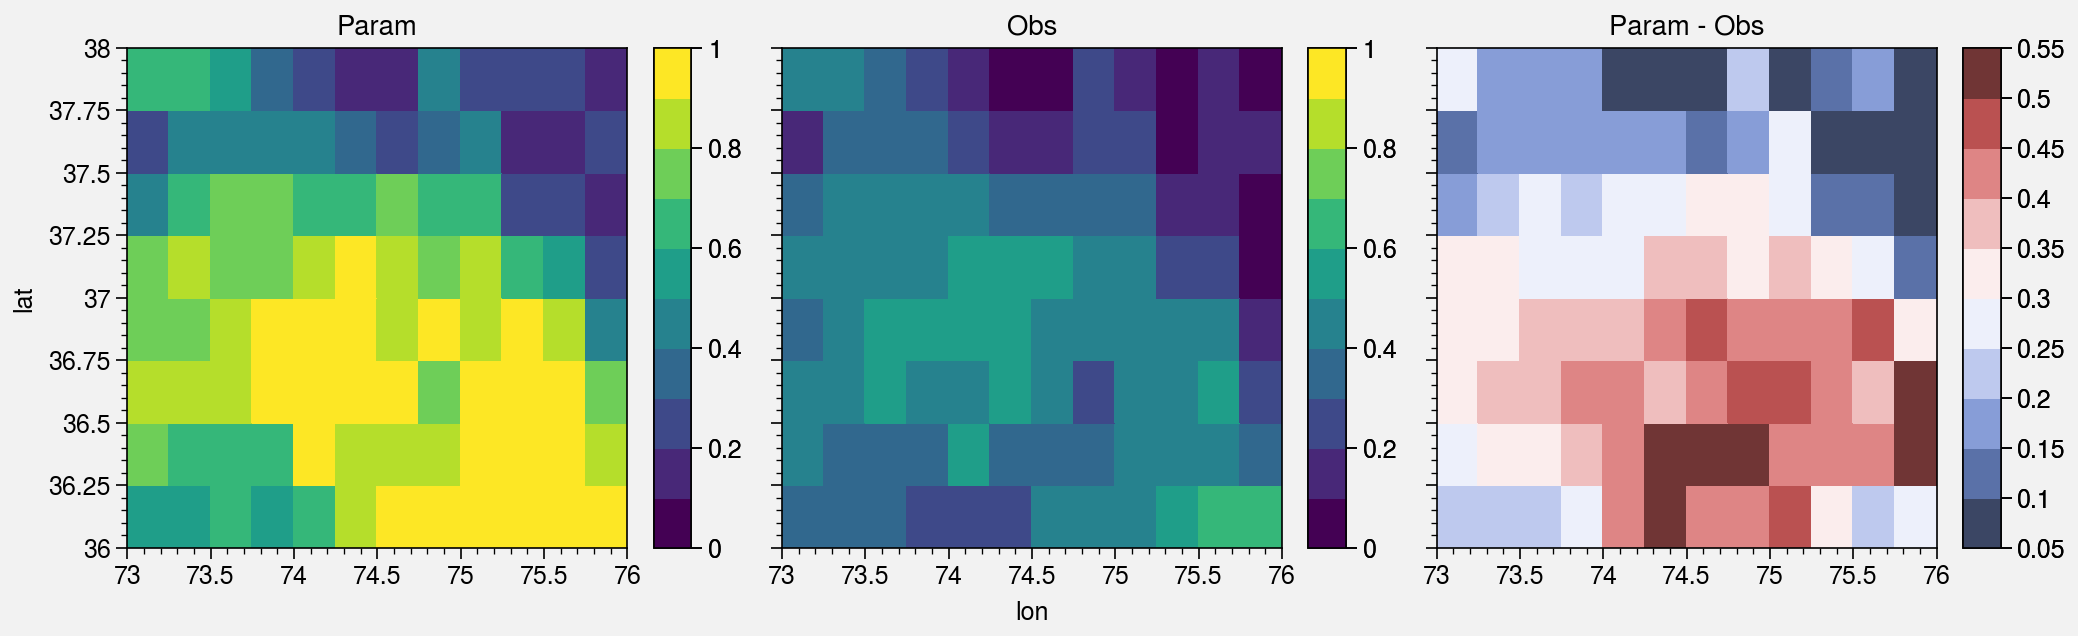

In [236]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

fig, axs = plot.subplots(ncols=3)

levels = plot.arange(0,1,0.05)

sca_param = sca_niu(sd_regrid, 0.01, swe_regrid/sd_regrid*1000, 50, 1)
sca_param.mean('Day').plot(ax=axs[0], levels=levels)

sca_regrid.mean('Day').plot(ax=axs[1], levels=levels)

(sca_param - sca_regrid).mean('Day').plot(ax=axs[2], cmap='Div')

for ax, title in zip(axs, ['Param', 'Obs', 'Param - Obs']):
    ax.format(title=title)    

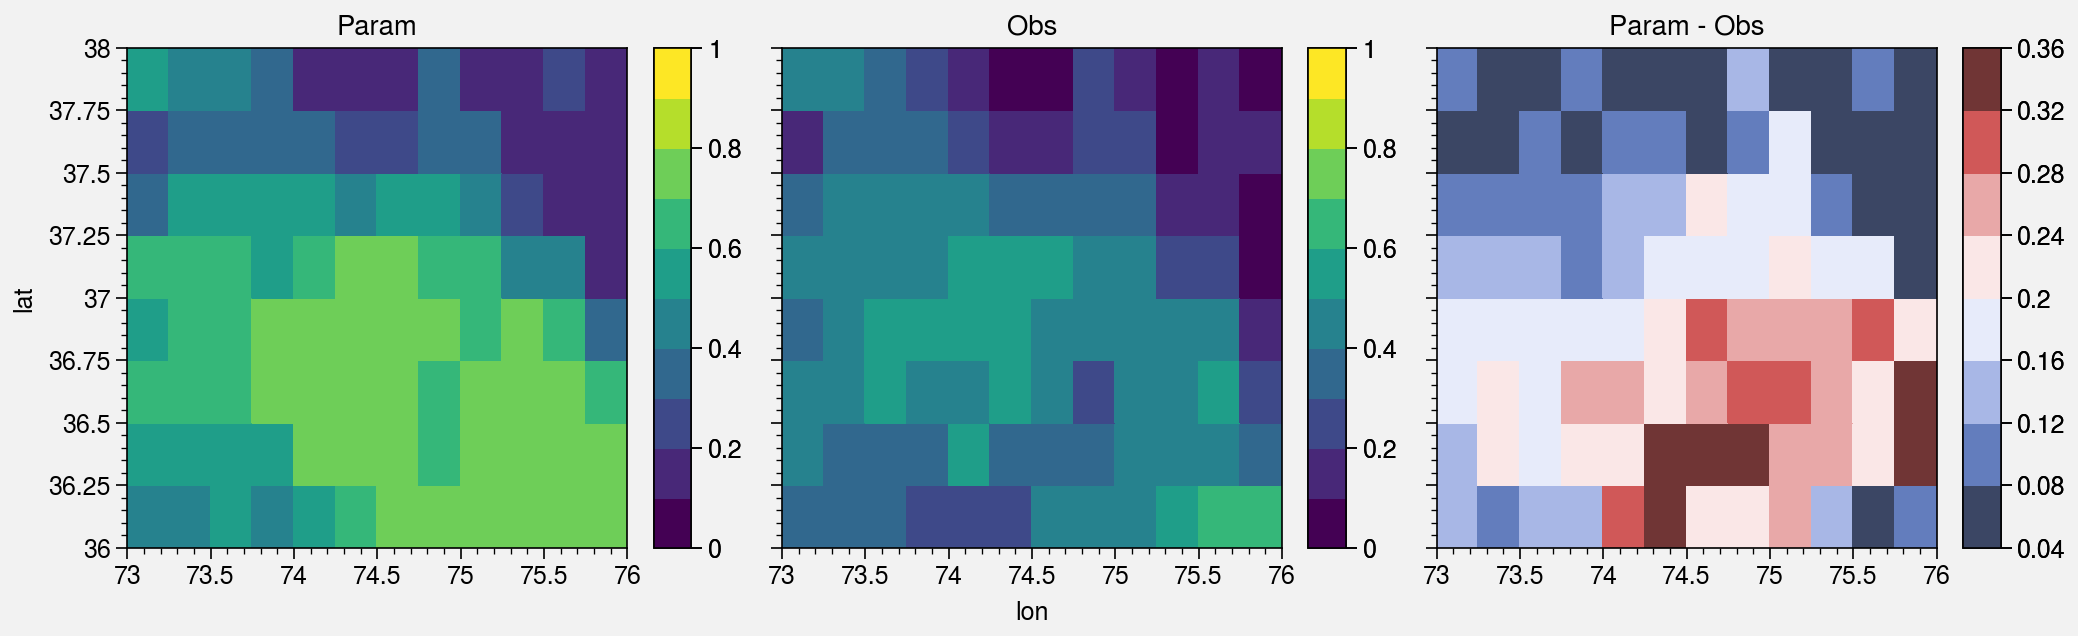

In [238]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

fig, axs = plot.subplots(ncols=3)

levels = plot.arange(0,1,0.05)

sca_param = sca_niu(sd_regrid, 0.01, swe_regrid/sd_regrid*1000, 100, 1)
sca_param.mean('Day').plot(ax=axs[0], levels=levels)

sca_regrid.mean('Day').plot(ax=axs[1], levels=levels)

(sca_param - sca_regrid).mean('Day').plot(ax=axs[2], cmap='Div')

for ax, title in zip(axs, ['Param', 'Obs', 'Param - Obs']):
    ax.format(title=title)    

In [ ]:
np.sqrt((sca_param - sca_regrid)**2)

In [265]:
sca_param.size

35136

## Try to optimize

### m

In [272]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

m_values = np.arange(0,10,0.1)
loss = []
for m in m_values:
    sca_param = sca_niu(sd_regrid, 0.01, swe_regrid/sd_regrid*1000, 100, m)
    loss.append(np.sqrt(np.sum((sca_param - sca_regrid)**2/sca_param.size)))

(<matplotlib.lines.Line2D at 0x14c3c02db0a0>,)

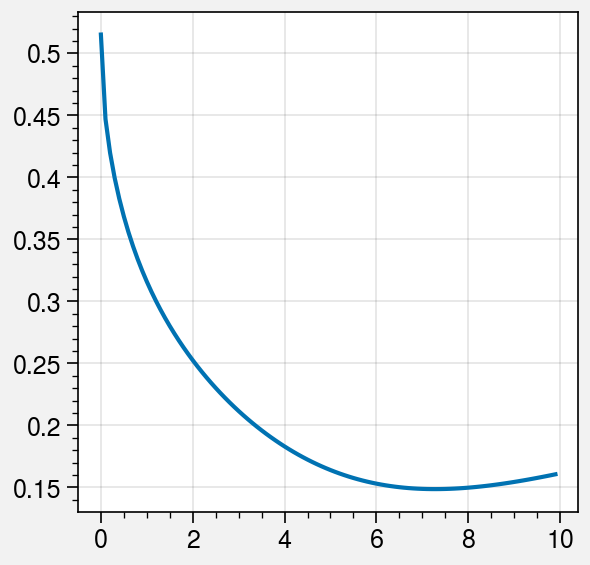

In [273]:
fig, axs = plot.subplots()

axs[0].plot(m_values, loss)

### rho_new

In [278]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

rho_new_values = np.arange(10,500,10)
loss = []
for rho_new in rho_new_values:
    sca_param = sca_niu(sd_regrid, 0.01, swe_regrid/sd_regrid*1000, rho_new, 7.3)
    loss.append(np.sqrt(np.sum((sca_param - sca_regrid)**2/sca_param.size)))

(<matplotlib.lines.Line2D at 0x14c3bf7eb250>,)

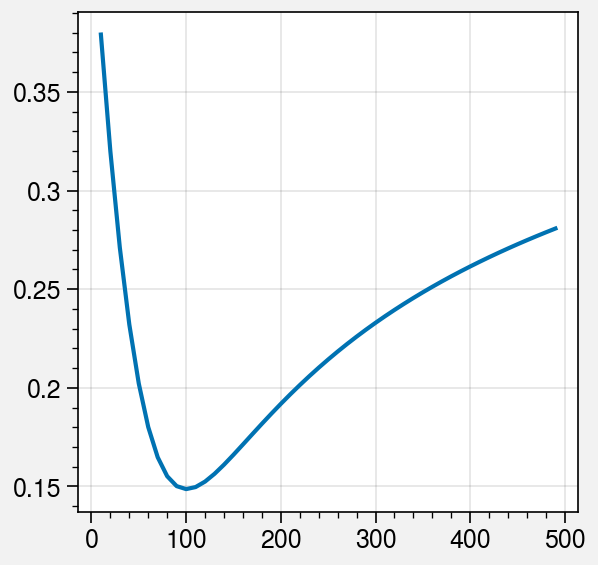

In [279]:
fig, axs = plot.subplots()

axs[0].plot(rho_new_values, loss)

In [280]:
rho_new_values[np.argmin(loss)]

100

### rho_new

In [285]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

z0_values = np.arange(0.001,0.2,0.001)
loss = []
for z0 in z0_values:
    sca_param = sca_niu(sd_regrid, z0, swe_regrid/sd_regrid*1000, 100, 7.3)
    loss.append(np.sqrt(np.sum((sca_param - sca_regrid)**2/sca_param.size)))

(<matplotlib.lines.Line2D at 0x14c3c052f520>,)

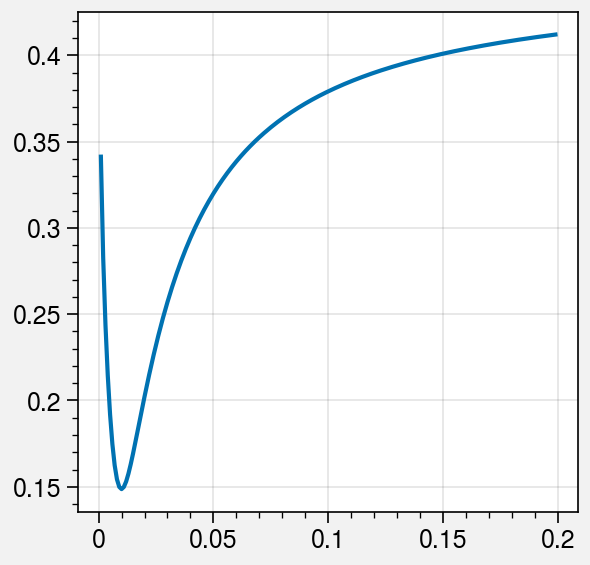

In [286]:
fig, axs = plot.subplots()

axs[0].plot(z0_values, loss)

In [287]:
z0_values[np.argmin(loss)]

0.010000000000000002

### m

In [297]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

m_values = np.arange(0,10,0.1)
loss = []
for m in m_values:
    sca_param = sca_niu(sd_regrid, 0.01, swe_regrid/sd_regrid*1000, 50, m)
    loss.append(np.sqrt(np.sum((sca_param - sca_regrid)**2/sca_param.size)))

(<matplotlib.lines.Line2D at 0x14c3be985ee0>,)

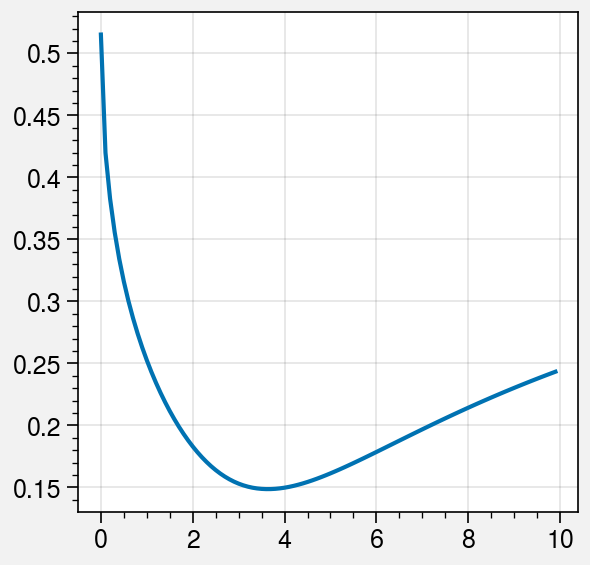

In [298]:
fig, axs = plot.subplots()

axs[0].plot(m_values, loss)

In [299]:
m_values[np.argmin(loss)]

3.6

### Plot

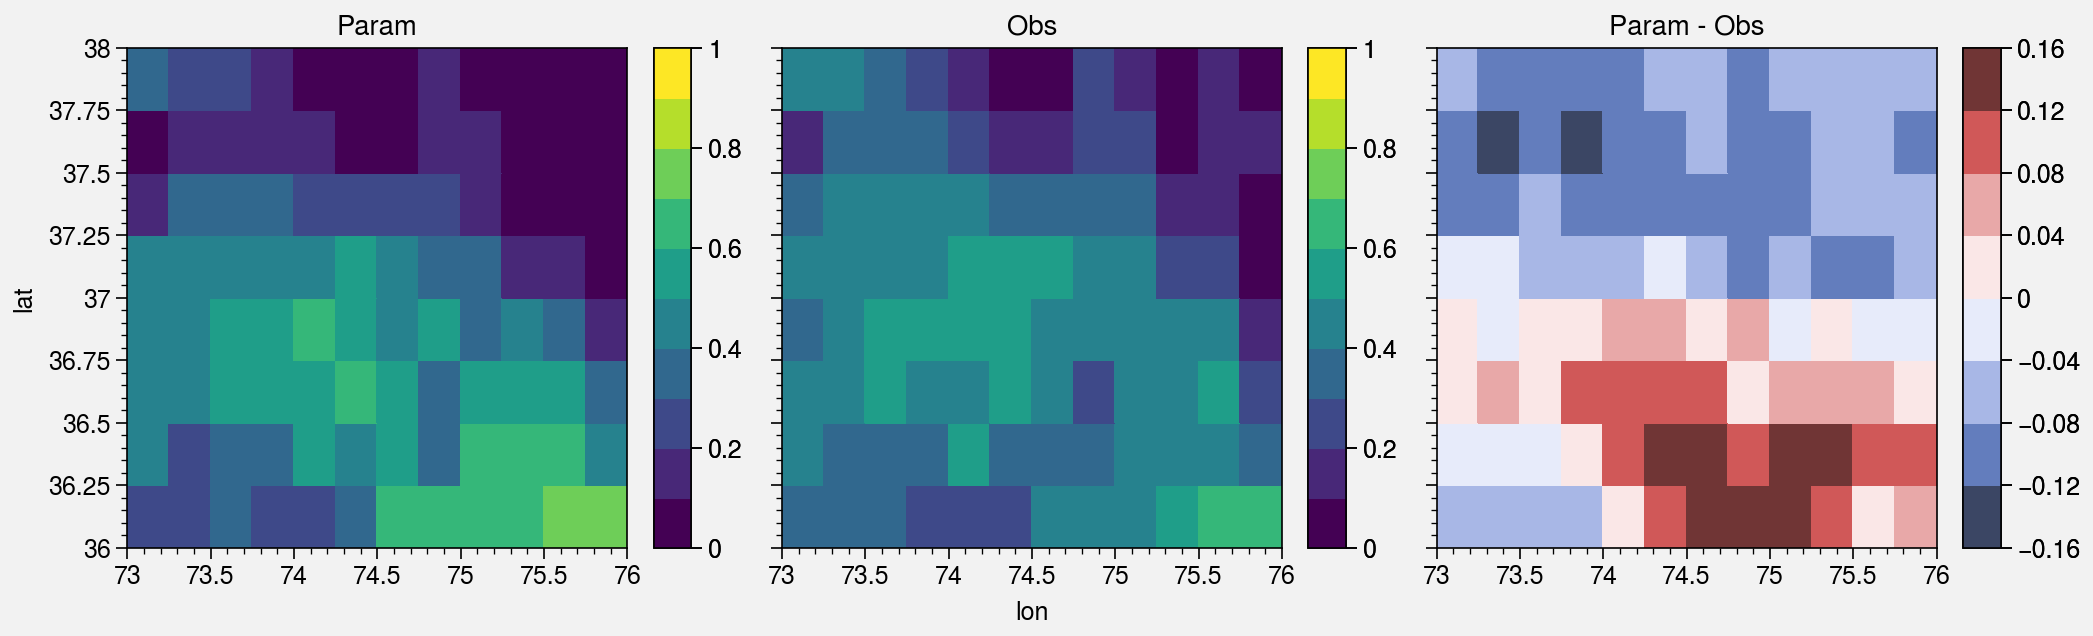

In [293]:
def sca_niu(d, z0, rho_snow, rho_new, m):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m))

fig, axs = plot.subplots(ncols=3)

levels = plot.arange(0,1,0.05)

sca_param = sca_niu(sd_regrid, 0.01, swe_regrid/sd_regrid*1000, 100, 7.3)
sca_param.mean('Day').plot(ax=axs[0], levels=levels)

sca_regrid.mean('Day').plot(ax=axs[1], levels=levels)

(sca_param - sca_regrid).mean('Day').plot(ax=axs[2], cmap='Div')

for ax, title in zip(axs, ['Param', 'Obs', 'Param - Obs']):
    ax.format(title=title)    

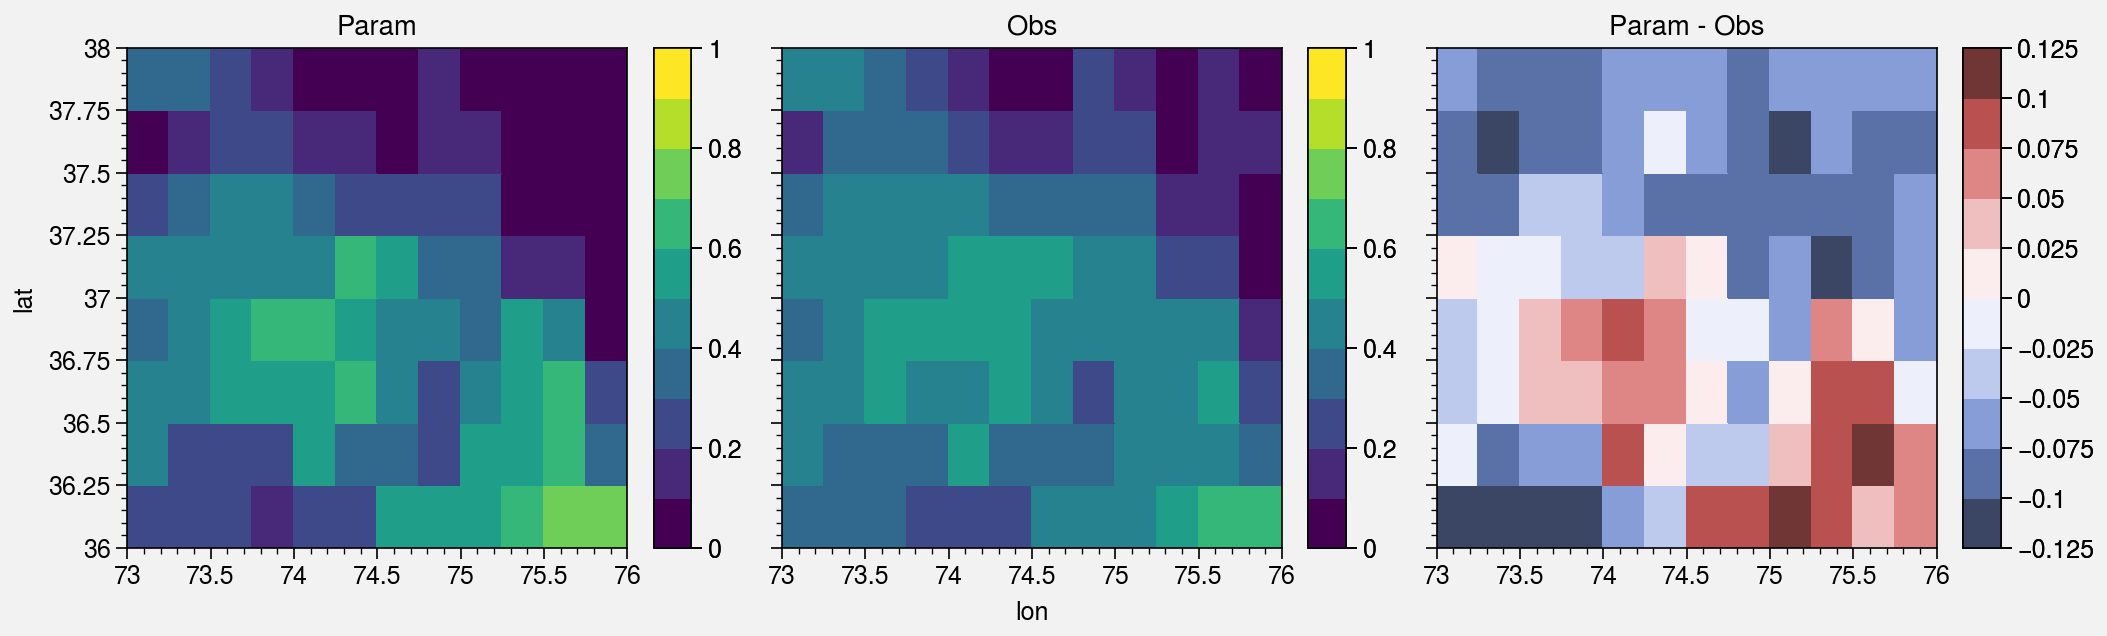

In [262]:
def sca_niu(d, z0, rho_snow, rho_new, m, std):
    return 0.8*np.tanh(d/(2.5*z0*(rho_snow/rho_new)*m+std/1300))

fig, axs = plot.subplots(ncols=3)

levels = plot.arange(0,1,0.05)

sca_param = sca_niu(sd_regrid, 0.01, swe_regrid/sd_regrid*1000, 50, 1, elevation_std)
sca_param.mean('Day').plot(ax=axs[0], levels=levels)

sca_regrid.mean('Day').plot(ax=axs[1], levels=levels)

(sca_param - sca_regrid).mean('Day').plot(ax=axs[2], cmap='Div')

for ax, title in zip(axs, ['Param', 'Obs', 'Param - Obs']):
    ax.format(title=title)    

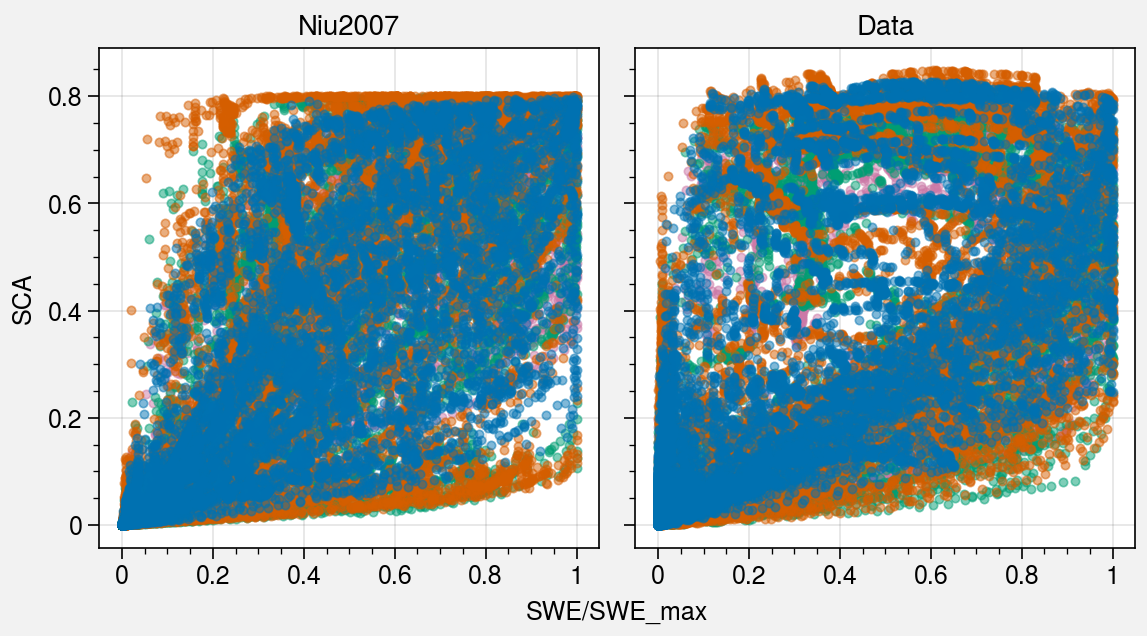

In [263]:
fig, axs = plot.subplots(ncols=2)

axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where(elevation_std < 400)).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[0].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 800))).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=7)
axs[0].format(title='Niu2007')

axs[1].scatter(((swe_regrid/swe_regrid.max('Day')).where(elevation_std < 400)).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[1].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[1].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[1].scatter(((swe_regrid/swe_regrid.max('Day')).where((elevation_std > 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=7)
axs[1].format(title='Data')

axs.format(xlabel='SWE/SWE_max', ylabel='SCA')

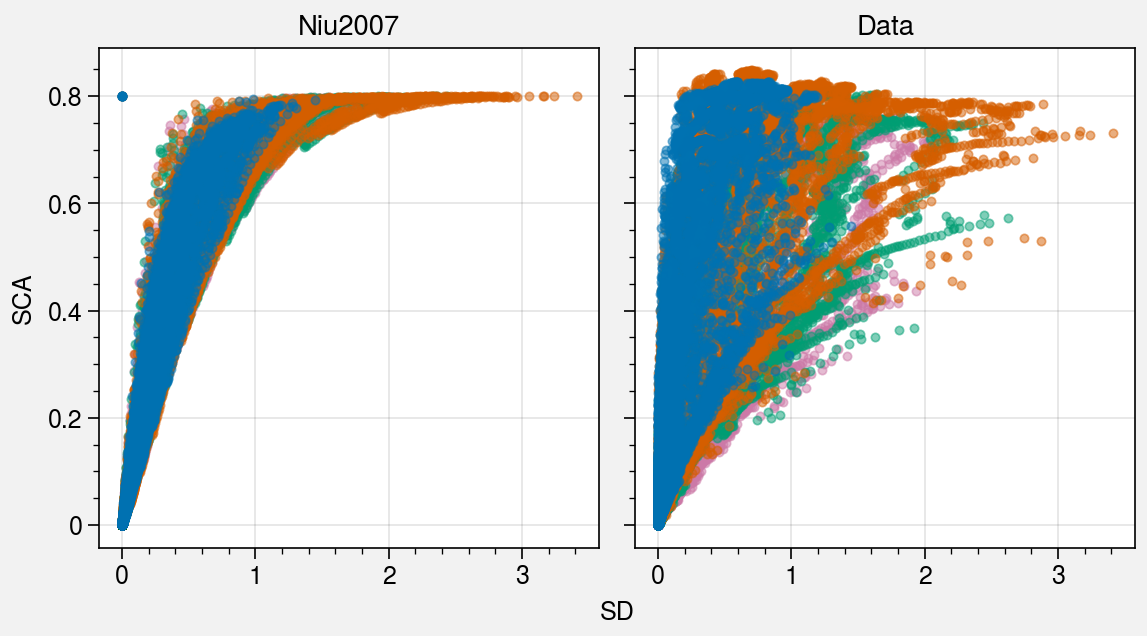

In [250]:
fig, axs = plot.subplots(ncols=2)

axs[0].scatter((sd_regrid.where(elevation_std < 400)).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[0].scatter((sd_regrid.where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[0].scatter((sd_regrid.where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[0].scatter((sd_regrid.where((elevation_std > 800))).values.flatten(), sca_param.values.flatten(), marker='.', alpha=0.5, zorder=7)
axs[0].format(title='Niu2007')

axs[1].scatter((sd_regrid.where(elevation_std < 400)).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=10)
axs[1].scatter((sd_regrid.where((elevation_std > 400) & (elevation_std < 600))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=9)
axs[1].scatter((sd_regrid.where((elevation_std > 600) & (elevation_std < 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=8)
axs[1].scatter((sd_regrid.where((elevation_std > 800))).values.flatten(), sca_regrid.values.flatten(), marker='.', alpha=0.5, zorder=7)
axs[1].format(title='Data')

axs.format(xlabel='SD', ylabel='SCA')

In [204]:
sca_regrid

<xarray.DataArray (Day: 366, lat: 8, lon: 12)>
array([[[6.14377515e-02, 5.60093400e-02, 5.61233552e-02, ...,
         3.35974753e-02, 7.88529645e-03, 5.71252070e-03],
        [9.35360885e-02, 8.00784309e-02, 1.18053150e-01, ...,
         2.21784951e-02, 2.09090399e-02, 2.35170574e-02],
        [8.88349104e-02, 1.55253783e-01, 2.51081434e-01, ...,
         2.28332543e-02, 1.91429413e-02, 3.03920206e-02],
        ...,
        [9.79397551e-02, 9.57141834e-02, 1.05348250e-01, ...,
         5.39241565e-02, 5.18618091e-02, 3.34341978e-02],
        [6.75409615e-02, 7.89878275e-02, 8.43402511e-02, ...,
         4.97956283e-02, 8.90622337e-02, 8.63072493e-02],
        [5.65716095e-02, 7.17161064e-02, 7.51590154e-02, ...,
         1.19901405e-01, 1.51635187e-01, 1.30172437e-01]],

       [[2.97872637e-02, 3.03872327e-02, 2.68056001e-02, ...,
         2.37050571e-02, 2.19197229e-03, 1.75326926e-03],
        [3.94170147e-02, 5.04492790e-02, 8.03400407e-02, ...,
         6.69185506e-02, 2.13503857e-02, 1.59099439e-02],
        [5.01287738e-02, 1.81113471e-01, 3.25796227e-01, ...,
         2.21288918e-01, 1.22250494e-01, 3.40410269e-02],
...
        [3.04467372e-02, 2.41834990e-02, 3.85051261e-02, ...,
         3.33721365e-02, 3.93935794e-02, 2.87744375e-02],
        [2.65900142e-02, 1.53597437e-02, 1.22266113e-02, ...,
         1.77519644e-02, 1.95935829e-02, 2.97521910e-02],
        [3.31743229e-02, 1.35545883e-02, 1.20198052e-02, ...,
         1.27405256e-02, 1.21559795e-02, 1.01858450e-02]],

       [[1.57540212e-02, 1.72684396e-02, 2.21376505e-02, ...,
         3.28610074e-01, 4.86722902e-01, 4.13760995e-01],
        [3.14464589e-02, 2.14378612e-02, 2.52144947e-02, ...,
         2.56522764e-01, 2.44051950e-01, 1.49948609e-01],
        [5.33466814e-02, 6.59899658e-02, 9.54320419e-02, ...,
         2.34042057e-01, 2.74216539e-01, 1.34357723e-01],
        ...,
        [6.35837774e-02, 6.65429055e-02, 7.44038079e-02, ...,
         4.75648982e-02, 5.05811733e-02, 3.43867856e-02],
        [5.58573733e-02, 5.90824008e-02, 5.67591615e-02, ...,
         2.14381331e-02, 2.94099485e-02, 3.61373526e-02],
        [5.55993290e-02, 5.26666478e-02, 4.78298754e-02, ...,
         2.31684726e-02, 2.18397103e-02, 1.72088952e-02]]])
Coordinates:
  * lon      (lon) float32 73.125 73.375 73.625 73.875 ... 75.375 75.625 75.875
  * lat      (lat) float32 36.125 36.375 36.625 36.875 ... 37.375 37.625 37.875
Dimensions without coordinates: Day
Attributes:
    regrid_method:  bilinear

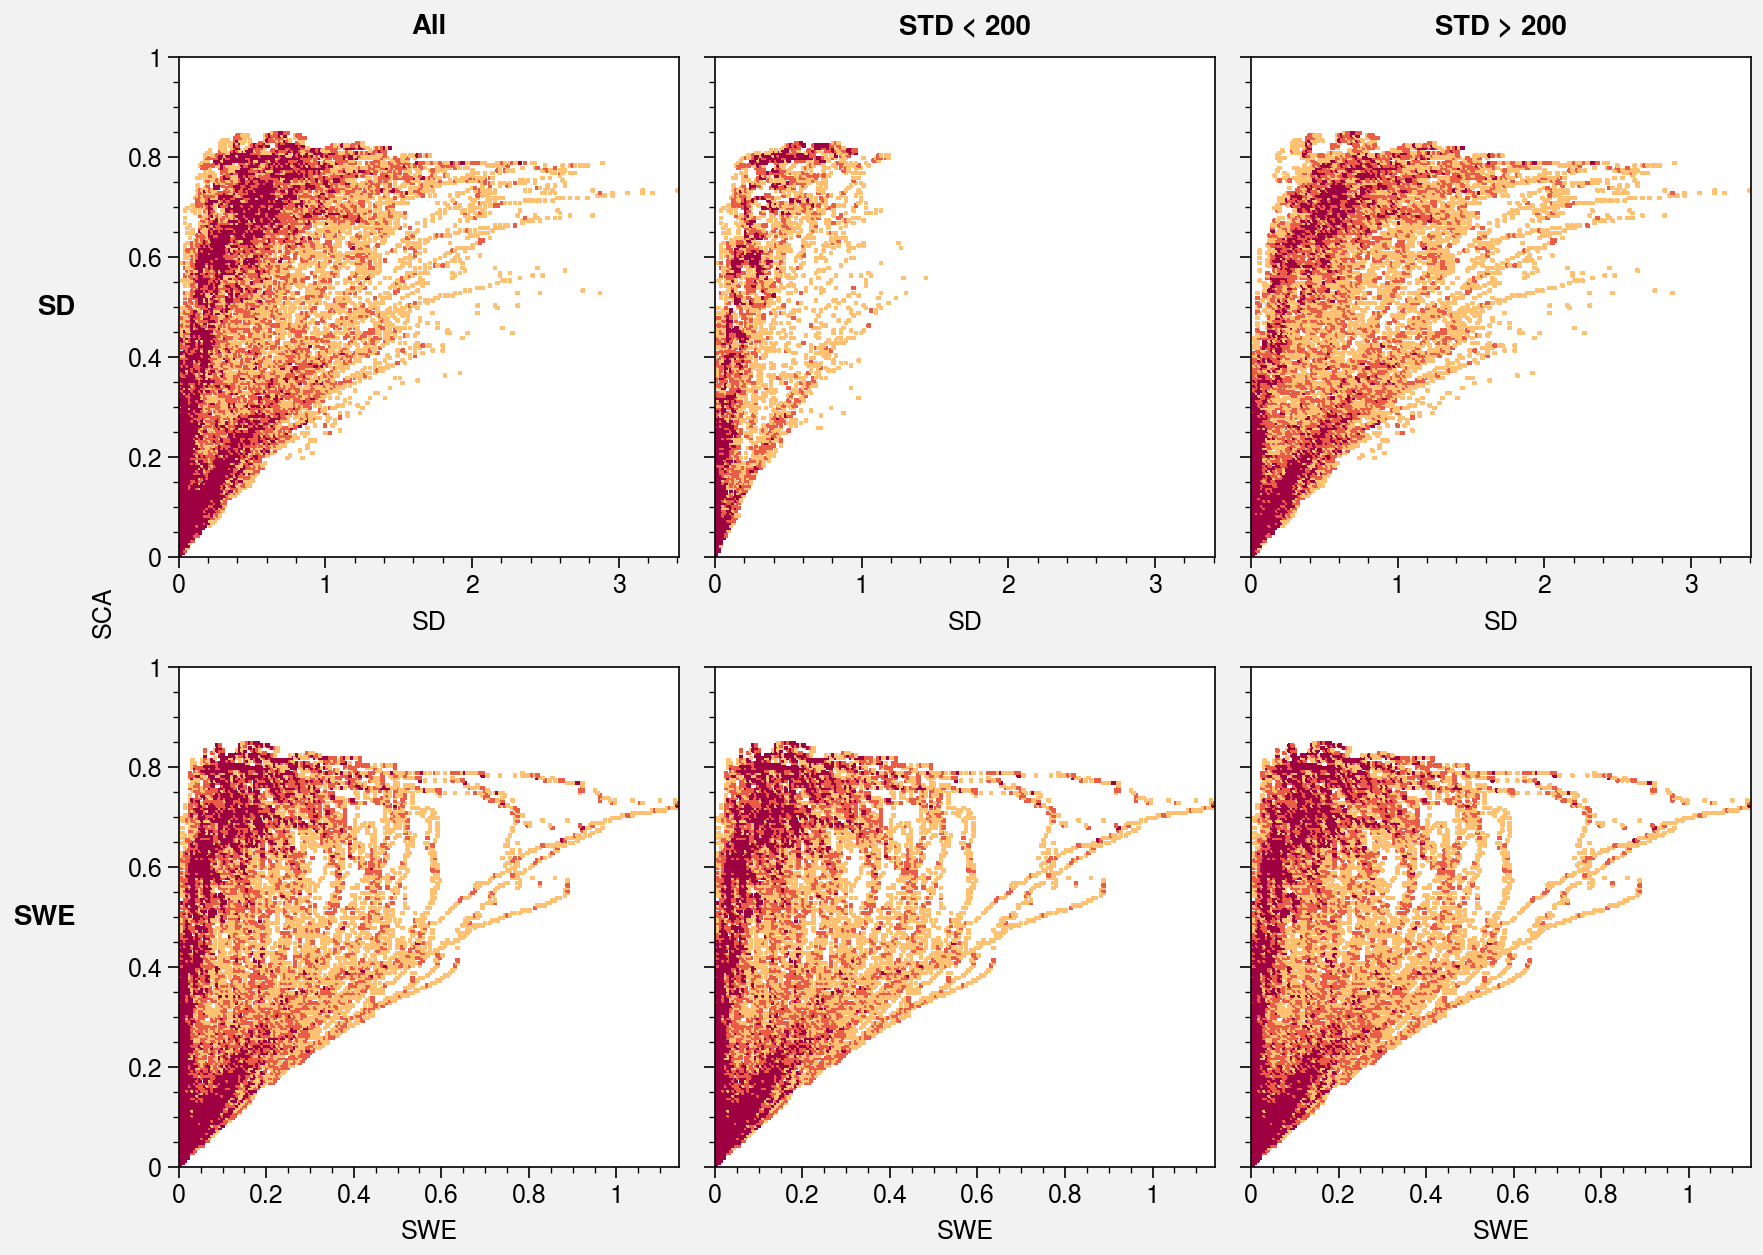

In [169]:
bins = 200
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1

fig, axs = plot.subplots(ncols=3, nrows=2, sharex=0)

# SD 

xylim = [[0, sd_regrid.max()], [0, 1]]

axs[0].hist2d(sd_regrid.values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[0].format(xlabel='SD', ylabel='SCA')

axs[1].hist2d((sd_regrid.where(elevation_std < 400)).values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[1].format(xlabel='SD', ylabel='SCA')

axs[2].hist2d((sd_regrid.where(elevation_std > 400)).values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[2].format(xlabel='SD', ylabel='SCA')


# SWE

xylim = [[0, swe_regrid.max()], [0, 1]]

axs[3].hist2d(swe_regrid.values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[3].format(xlabel='SWE', ylabel='SCA')

axs[4].hist2d(swe_regrid.values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[4].format(xlabel='SWE', ylabel='SCA')

axs[5].hist2d(swe_regrid.values.flatten(), sca_regrid.values.flatten(),
             bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin)
axs[5].format(xlabel='SWE', ylabel='SCA')


axs.format(
    rowlabels=['SD', 'SWE'],
    collabels=['All', 'STD < 200', 'STD > 200']
)

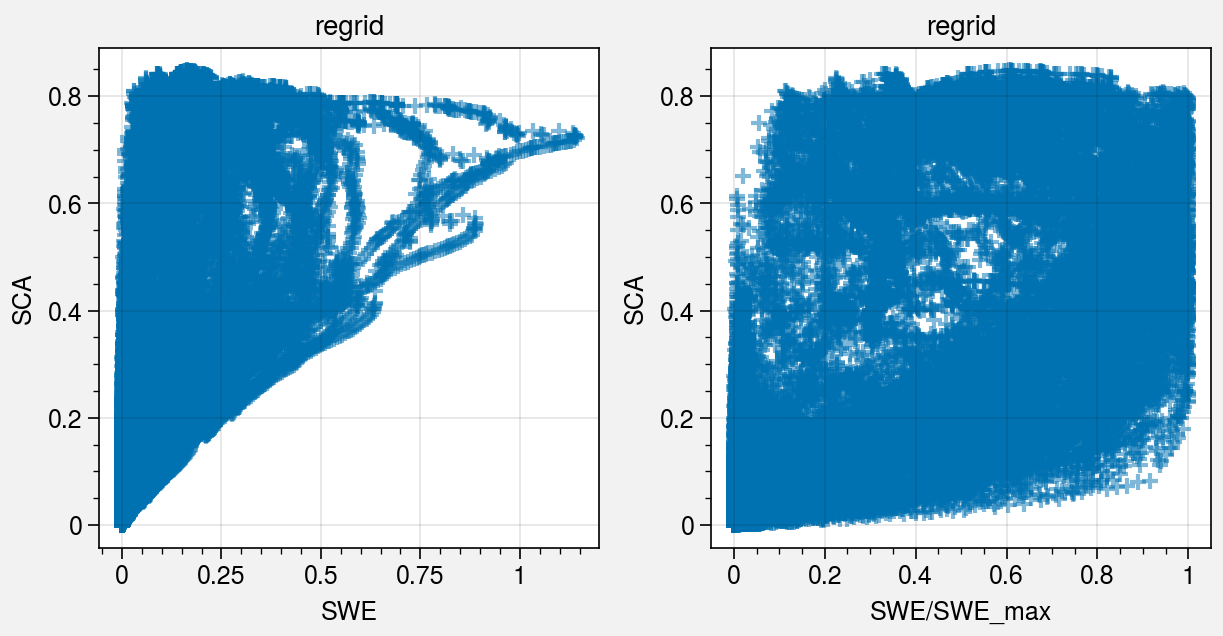

In [87]:
fig, axs = plot.subplots(ncols=2, nrows=1, share=0)

axs[0].scatter(swe_regrid.values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[0].format(xlabel='SWE', ylabel='SCA', title='regrid')

axs[1].scatter((swe_regrid/swe_regrid.max('Day')).values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[1].format(xlabel='SWE/SWE_max', ylabel='SCA', title='regrid')

### Check elevation